after copying and extracting the data on EC2 instance We want read the data for each line extratc the path to the camera image path
but we need to update the path cause it's not on out local machin
anymore, and it's on the AWS instance.

# easy way to update the path
Split the path on it's slashes and then extract the final token
which will be file name.
then we can add that file name to the end of the image directory
here on the AWS instance.
Now that we have the current path we can use opencv to load the image
and append it to the our list of images
we can do the same thing for the steering measurements, which will serve 
as our output labels, but with this difference that there would be no path
or no images to handle, just simply extract the 4th token from the csv line

In [1]:
import cv2
import csv
import numpy as np
import os
import sklearn
from sklearn.model_selection import train_test_split

# The following two functions are 
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(320,160))    
    return image_tr,steer_ang

def random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    
    if np.random.randint(2)==1:
        random_bright = .25
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


In [2]:

samples = []
with open ('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

del(samples[0])
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)

    while 1:
        
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:

                name1 = 'data/IMG/' + batch_sample[0].split('/')[-1]
                name2 = 'data/IMG/' + batch_sample[1].split('/')[-1]
                name3 = 'data/IMG/' + batch_sample[2].split('/')[-1]

                center_image = cv2.imread(name1)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_image = augment_brightness(center_image)
                center_angle = float(batch_sample[3])                
                #center_image, center_angle = trans_image(center_image, center_angle, 40)
                
                left_image = cv2.imread(name2)
                left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
                left_image = augment_brightness(left_image)
                left_angle = center_angle + 0.25
                #left_image, left_angle = trans_image(left_image, left_angle, 40)
                
                right_image = cv2.imread(name3)
                right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
                right_image = augment_brightness(right_image)
                right_angle = center_angle - 0.25
                #right_image, right_angle = trans_image(right_image, right_angle, 40)

                images.append(center_image)
                images.append(left_image)
                images.append(right_image)
                
                angles.append(center_angle)
                angles.append(left_angle)
                angles.append(right_angle)
                
                augmented_images, augmented_angles = [], []
                for image, angle in zip(images, angles):
                    augmented_images.append(image)
                    augmented_angles.append(angle)
                    augmented_images.append(cv2.flip(image,1))
                    augmented_angles.append(angle * -1.0)
           
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            (X_train, y_train)= sklearn.utils.shuffle(X_train, y_train)
            yield (X_train, y_train)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
        
print("Data is loaded")  

Data is loaded


# Building Basic Model
Now we are going to build the most basic NW possible
Just to verify that everthing is working fine.
This NW is going to be a flattened image connected to a
single output node. This single output node is going to predict 
the steering angle, which makes this a regression network.

For a Classification Netwrok we might need to apply a softmax activation function to the output layer. But for a regression network like this we just need a single output node to directly predict the steering angle for us.

By default Keras trains for 10 epochs. But we can see the validation loss decreases for the first 7 epochs and then it starts to climbing again.
This is a sign that maybe we are over fitting the data. The validation loss should decrease for almost all the epochs.

Using TensorFlow backend.


Epoch 1/5
6336/6428 [============================>.] - ETA: 0s - loss: 0.0894

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6528/6428 [==============================] - 18s - loss: 0.0879 - val_loss: 0.0406
Epoch 2/5
6528/6428 [==============================] - 15s - loss: 0.0385 - val_loss: 0.0275
Epoch 3/5
6528/6428 [==============================] - 14s - loss: 0.0252 - val_loss: 0.0196
Epoch 4/5
6528/6428 [==============================] - 15s - loss: 0.0220 - val_loss: 0.0184
Epoch 5/5
6528/6428 [==============================] - 14s - loss: 0.0227 - val_loss: 0.0225
dict_keys(['loss', 'val_loss'])


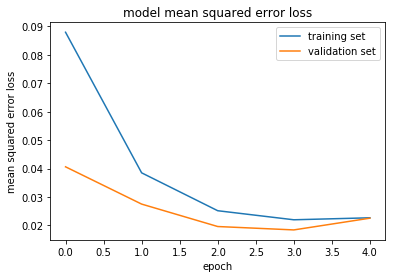

model saved!


In [3]:

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers.pooling import AveragePooling2D

ch, row, col = 3, 80, 320 # trimmed image format


model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3),output_shape=(160,320,3)))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="elu"))
model.add(Dropout(0.3))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation="elu"))
#model.add(Dropout(0.5))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation="elu"))
model.add(Dropout(0.3))
model.add(Convolution2D(64,3,3, activation="elu"))
model.add(Dropout(0.3))
model.add(Convolution2D(64,3,3, activation="elu"))
#model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
# model.summary()
# For the loss function we use mean square , or MSE, which is differnt
# than cross_entropy function, again becuase this is a regression network 
# not a classifer network.

# We want to minimize the error between the stearing measurementss that the 
# Network predicts and the ground truth steering measurement.
# MSE is good loss function for this.

model.compile(loss='mse', optimizer='adam')

# Once the model is compiled we'll train the feature and label arrays
# we just build.
# WE also shuffle the data and also split off 20% of the data to use 
# for validation set.

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
# Now we will save the model and download it onto our local machine,
# and see if it works for driving the simulator.

model.save('model.h5')
print("model saved!")
exit()


Next step is to download this model toour local machine.

 
# How do you know when you have collected enough data? 
Machine learning involves trying out ideas and testing them to see if they work. If the model is over or underfitting, then try to figure out why and adjust accordingly.
​
Since this model outputs a single continuous numeric value, one appropriate error metric would be mean squared error. 
1. If the mean squared error is high on both a training and validation set, the model is underfitting. 
2. If the mean squared error is low on a training set but high on a validation set, the model is overfitting. Collecting more data can help improve a model when the model is overfitting.
3. What if the model has a low mean squared error on both the training and validation sets, but the car is falling off the track? Try to figure out the cases where the vehicle is falling off the track. Does it occur only on turns? Then maybe it's important to collect more turning data. The vehicle's driving behavior is only as good as the behavior of the driver who provided the data.
In [ ]:

​


# Insights:
As you can imagine, if you record the training data driving through the center of the track, then most of your recorded steering angles will be close to zero. This data will have bias for driving straight. Since the training track has more left turns than right, it also had a slight bias for turing left.

To solve this problem I tried to record more data when I was purposly drive off road and record the recovery, but it was very difficult! Beside that, dealing with uploading and removing a big chunk of data on AWS wsa extremely time consuming and I didn't find a faster way of doing it.(some help from Udacity for future students would be great - A feedback right there:D)
So I gave up on that and went back to the data set provided by Udacity. I added a Color to YUV filter to the preprocessing steps in my generator, but didn't get much improvement. Still the car was driving off road at some point. 


## How did visualization of loss helped me?
In an amazing post from one the forum's mentor (subodh malgonde) I learned that general rule of thumb is:

1. If your training loss is low and validation loss is higher and they have converged at 2 largely different values then your model is overfitting the training data. Things that can cure overfitting are getting more training data, increasing regularization/dropout or trying out a simpler/smaller network. If the validation loss has not converged and is reducing with each epoch then trying out more epochs may help you.

2. If your training loss and validation loss are very close, but both a are high then your model is underfitting. Things that can cure underfitting are increasing the complexity of your network or reducing regularization/dropout. Getting more data or increasing the epochs won't help you in this case.

Using this rules, I realized I was using too many dropouts